# Acknowledgements

Notebook developed by Andrew Ferguson for the UChicago course MENG15100: Machine Learning and Artificial Intelligence for Molecular Discovery and Engineering.

## Data

Let's start by importing some training data from a csv file using pandas.

We will start working with a simple data set with one input variable $x$ and one output variable $y$.

In [13]:
import pandas as pd

# Replace with the actual raw GitHub URL of your file
github_raw_url = 'https://raw.githubusercontent.com/andrewlferguson/MENG15100/main/notebooks/M3/linreg.csv'

# Load the data into a Pandas DataFrame
df = pd.read_csv(github_raw_url)

# Show the data
print(df)

           x          y
0   0.526316   2.039261
1   1.052632   4.926956
2   1.578947   7.993428
3   2.105263   5.794851
4   2.631579   7.110673
5   3.157895  12.053162
6   3.684211  11.745396
7   4.210526  10.587367
8   4.736842  13.927225
9   5.263158  13.231059
10  5.789474  14.542225
11  6.315789  17.273398
12  6.842105  14.278703
13  7.368421  15.971217
14  7.894737  19.612267
15  8.421053  20.026969
16  8.947368  23.996916
17  9.473684  22.868162


It is our goal to fit a linear regression model to these data of the form $y = \phi_0 + \phi_1 x$.

Recall that $\{\phi_0, \phi_1\}$ are the trainable parameters of our model, $x$ is the input data, and $y$ is the output data.

In this simple example, mainly to make plotting easy, the $x$ data are just one dimensional (i.e., there is a single $x$ feature associated with each of the 18 instances or in the training data).

# Human Learning

Now let's do some graphical exploration and "human learning" where we will guess the optimal values of the linear regression fitting parameters $\phi_0$ (intercept) and $\phi_1$ (slope).

We will use matplotlib to make an interactive plot.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider

# Replace with the actual raw GitHub URL of your file
github_raw_url = 'https://raw.githubusercontent.com/andrewlferguson/MENG15100/main/notebooks/M3/linreg.csv'

# Load the data into a Pandas DataFrame
df = pd.read_csv(github_raw_url)

# Load CSV data
x = df['x'].values
y = df['y'].values

# Define the interactive plot function
def plot_line(slope=2.0, intercept=1.0):
    y_line = slope * x + intercept

    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, color='blue', label='Data')
    plt.plot(x, y_line, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Interactive Linear Fit')
    plt.grid(True)
    plt.legend()
    plt.show()

# Sliders for slope and intercept
interact(
    plot_line,
    slope=FloatSlider(value=2.0, min=-10, max=10, step=0.1, description='Slope'),
    intercept=FloatSlider(value=1.0, min=-10, max=10, step=0.1, description='Intercept')
)


interactive(children=(FloatSlider(value=2.0, description='Slope', max=10.0, min=-10.0), FloatSlider(value=1.0,…

<function __main__.plot_line(slope=2.0, intercept=1.0)>

What appears to be a good choice for $\phi_0$ (intercept) and $\phi_1$ (slope)?

Enter them here:

In [27]:
phi_0_HUMAN = 0.0
phi_1_HUMAN = 0.0

# Machine Learning

OK, now let's let the machine do the work by asking it to find the $\boldsymbol\phi = \{\phi_0,\phi_1\}$ that minimize the least squares loss function $L[\boldsymbol\phi] = \sum_i (\hat y_i - y_i)^2$.

We recall that the loss function is the sum of square residuals: $y_i$ is the true value of $y$ in data instance $i$ and $\hat y_i = f(x_i) = \phi_0 + \phi_1 x_i$ is the prediction of our model.

The learning algorithm will optimize $\boldsymbol\phi = \{\phi_0,\phi_1\}$ by finding the lowest point on the loss lanscape $L[\boldsymbol\phi]$.

One way to find the minimum is by gradient descent and this is the method of choice for large machine learning problems. For linear regression, it turns out that there is a closed form analytical solution that we can use to get there more efficiently, but we wind up in the same place either way.

We will use scikit-learn (sklearn) to solve the problem for us.

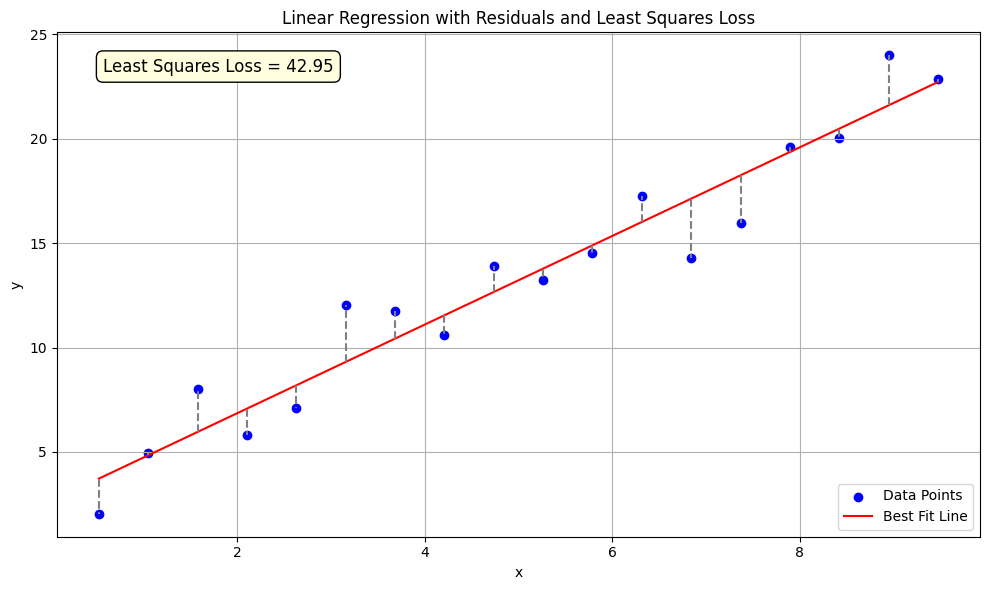

Best Fit Slope (phi_1): 2.12
Best Fit Intercept (phi_0): 2.61


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load CSV data
x = df['x'].values.reshape(-1, 1)
y = df['y'].values.reshape(-1, 1)

# Fit linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Get slope and intercept
slope = model.coef_[0]
intercept = model.intercept_

# Calculate residuals and loss
residuals = y - y_pred
squared_loss = np.sum(residuals**2)

# Plot data, best-fit line, and residuals
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data Points')
plt.plot(x, y_pred, color='red', label='Best Fit Line')

# Plot residuals
for xi, yi, ypi in zip(x, y, y_pred):
    plt.vlines(xi, ypi, yi, color='gray', linestyle='dashed')

# Annotate least squares loss
plt.text(0.05, 0.95, f'Least Squares Loss = {squared_loss:.2f}',
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='black'))

# Final touches
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression with Residuals and Least Squares Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Reporting out best fit slope and intercept
print(f"Best Fit Slope (phi_1): {slope[0]:.2f}")
print(f"Best Fit Intercept (phi_0): {intercept[0]:.2f}")

# Introducing nonlinearities

We will now consider a more interesting data set that exhibits a nonlinear relationship in $y = f(x)$ and that is therefore poorly fitted by a linear model $y = \phi_0 + \phi_1 x$.

Remarkably, we can use all of the tools of linear regression to make a nonlinear fit. How? We can trick the algorithm to operate on nonlinear features. We add nonlinearities not into the model, but ask a linear model to operate on nonlinear features.

## Example 1

In this first example case, we will stick to a 1D input variable $x$ and introduce nonlinearities by constucting additional features that are nonlinear versions of $x$.

We will allow different features to be turned on and off, and the most complex model will look like:

$y = \phi_0 + \phi_1 x + \phi_2 x^2 + \phi_3 x^3 + \phi_4 x^4 + \phi_5 \ln(x) + \phi_6 \sin(x) + \phi_7 \cos(x) $

In [7]:
# Install ipywidgets in Colab
!pip install ipywidgets --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Generate a nonlinear dataset ---
np.random.seed(0)
x = np.linspace(1, 10, 100)
y = 2 * x**2 - 3 * x + 4*np.sin(x) + np.random.normal(scale=5, size=len(x))  # Nonlinear function

df = pd.DataFrame({'x': x, 'y': y})

# --- Define available transformations ---
transformations = {
    'x': lambda x: x,
    'x^2': lambda x: x**2,
    'x^3': lambda x: x**3,
    'x^4': lambda x: x**4,
    'ln(x)': lambda x: np.log(x),
    'sin(x)': lambda x: np.sin(x),
    'cos(x)': lambda x: np.cos(x)
}

# --- Create checkboxes for each term ---
checkboxes = {
    name: widgets.Checkbox(value=(name in ['x']), description=name)
    for name in transformations
}

# --- Output area for plot ---
output = widgets.Output()

# --- Generate selected features matrix ---
def get_selected_features(x):
    features = []
    labels = []
    for name, func in transformations.items():
        if checkboxes[name].value:
            features.append(func(x))
            labels.append(name)
    if not features:
        return None, None
    X = np.vstack(features).T
    return X, labels

# --- Plotting and regression update function ---
def update_plot(change=None):
    with output:
        clear_output(wait=True)

        X, labels = get_selected_features(df['x'].values)
        if X is None:
            print("Please select at least one feature.")
            return

        y = df['y'].values

        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        residuals = y - y_pred
        loss = np.sum(residuals ** 2)

        # Sort for plotting smooth lines
        x_vals = df['x'].values
        sort_idx = np.argsort(x_vals)
        x_sorted = x_vals[sort_idx]
        y_pred_sorted = y_pred[sort_idx]

        # --- Plot ---
        plt.figure(figsize=(10, 6))
        plt.scatter(x_vals, y, color='blue', label='Data Points')
        plt.plot(x_sorted, y_pred_sorted, color='red', label='Model Fit')

        # Residuals
        for xi, yi, ypi in zip(x_vals, y, y_pred):
            plt.vlines(xi, yi, ypi, color='gray', linestyle='dashed')

        # Coefficient annotation
        coef_str = '\n'.join([f'{lbl} = {coef:.2f}' for lbl, coef in zip(labels, model.coef_)])
        plt.text(0.05, 0.95,
                 f'Intercept = {model.intercept_:.2f}\n' + coef_str + f'\nLoss = {loss:.2f}',
                 transform=plt.gca().transAxes,
                 fontsize=11,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='black'))

        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Custom Linear Regression with Nonlinear Data")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# --- Attach update listeners ---
for cb in checkboxes.values():
    cb.observe(update_plot, names='value')

# --- Display the GUI ---
selectors = widgets.VBox(list(checkboxes.values()))
display(widgets.HBox([selectors, output]))
update_plot()


## Example 2

In this second example case, we will consider a 2D input variable $\boldsymbol x = \{x_1,x_2\}$ and introduce nonlinearities by constucting additional features that are nonlinear versions of $x_1$ and $x_2$.

We will allow different features to be turned on and off, and the most complex model will look like:

$y = \phi_0 + \phi_1 x_1 + \phi_2 x_2 + \phi_3 x_1^2 + \phi_4 x_2^2 + \phi_5 x_1 x_2 + \phi_6 \sin(x_1) + \phi_7 \sin(x_2) + \phi_8 sin(x_1 x_2)$

Of course now we will need to make a 3D plot since we have one output variable $y$ and two input variables $x_1$ and $x_2$.

In [8]:
# Install ipywidgets in Colab
!pip install ipywidgets --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D

# --- Generate nonlinear 2D data ---
np.random.seed(0)
x1 = np.linspace(-3, 3, 30)
x2 = np.linspace(-3, 3, 30)
X1, X2 = np.meshgrid(x1, x2)
x1_flat = X1.flatten()
x2_flat = X2.flatten()

# True function (nonlinear)
y = 1.5 * x1_flat - 2.0 * x2_flat + 0.8 * x1_flat * x2_flat + np.sin(x1_flat) + np.random.normal(0, 1, x1_flat.shape[0])

df = pd.DataFrame({'x1': x1_flat, 'x2': x2_flat, 'y': y})

# --- Define transformations ---
transformations = {
    'x1': lambda x1, x2: x1,
    'x2': lambda x1, x2: x2,
    'x1^2': lambda x1, x2: x1**2,
    'x2^2': lambda x1, x2: x2**2,
    'x1*x2': lambda x1, x2: x1 * x2,
    'sin(x1)': lambda x1, x2: np.sin(x1),
    'sin(x2)': lambda x1, x2: np.sin(x2),
    'sin(x1*x2)': lambda x1, x2: np.sin(x1 * x2)
}

# --- Create checkboxes for terms ---
checkboxes = {
    name: widgets.Checkbox(value=(name in ['x1', 'x2']), description=name)
    for name in transformations
}

output = widgets.Output()

# --- Feature generation ---
def get_selected_features(x1, x2):
    features = []
    labels = []
    for name, func in transformations.items():
        if checkboxes[name].value:
            features.append(func(x1, x2))
            labels.append(name)
    if not features:
        return None, None
    X = np.vstack(features).T
    return X, labels

# --- Plotting and regression update ---
def update_plot(change=None):
    with output:
        clear_output(wait=True)

        x1_vals = df['x1'].values
        x2_vals = df['x2'].values
        y_vals = df['y'].values

        X, labels = get_selected_features(x1_vals, x2_vals)
        if X is None:
            print("Please select at least one feature.")
            return

        # Fit regression
        model = LinearRegression()
        model.fit(X, y_vals)
        y_pred = model.predict(X)
        residuals = y_vals - y_pred
        loss = np.sum(residuals ** 2)

        # For plotting surface
        x1_grid = np.linspace(-3, 3, 40)
        x2_grid = np.linspace(-3, 3, 40)
        X1g, X2g = np.meshgrid(x1_grid, x2_grid)
        X1g_flat = X1g.flatten()
        X2g_flat = X2g.flatten()

        X_grid, _ = get_selected_features(X1g_flat, X2g_flat)
        y_grid_pred = model.predict(X_grid).reshape(X1g.shape)

        # --- 3D Plot ---
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Surface
        ax.plot_surface(X1g, X2g, y_grid_pred, alpha=0.6, cmap='viridis', edgecolor='none')

        # Data points
        ax.scatter(x1_vals, x2_vals, y_vals, color='red', s=10, label='Data Points')

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('y')
        ax.set_title("3D Linear Regression Surface")

        # Coefficient display
        coef_str = '\n'.join([f'{lbl} = {coef:.2f}' for lbl, coef in zip(labels, model.coef_)])
        print(f'Intercept: {model.intercept_:.2f}')
        print(coef_str)
        print(f'Least Squares Loss: {loss:.2f}')

        plt.tight_layout()
        plt.show()

# --- Attach checkbox callbacks ---
for cb in checkboxes.values():
    cb.observe(update_plot, names='value')

# --- Display GUI ---
selectors = widgets.VBox(list(checkboxes.values()))
display(widgets.HBox([selectors, output]))
update_plot()


# Regularization

Regularization of a linear regression model adds some additional constraints that guard against overfitting by pushing the model towards simpler, more robust solutions that perform well on new data rather than overfitting to the training data.

A standard way to introduce regularization is through an additional penalty term in the linear regression least squares loss function $L[\boldsymbol \phi] = \sum_i \left(f[x_i,\boldsymbol\phi] - y_i \right)^2$ that punishes large values of the coefficients $\phi_i$ and seeks to **shrink** them towards zero.

Two popular flavors of this regularization pernalty are:

1. Ridge regression (L2 regression) in which we add a penality on the sum of the squared values of the coefficients: $L[\boldsymbol \phi] = \sum_i \left(f[x_i,\boldsymbol\phi] - y_i \right)^2 + \lambda \sum_k \phi_k^2$

2. Lasso regression (L1 regression) in which we add a penality on the sum of the absolute values of the coefficients: $L[\boldsymbol \phi] = \sum_i \left(f[x_i,\boldsymbol\phi] - y_i \right)^2 + \lambda \sum_k |\phi_k|$

The strength of the penalty, and therefore how much we shrink the coefficients towards zero, is controlled by the hyperparameter $\lambda$. We can think of $\lambda$ as controlling the trade-off between fitting the data well (first term) and minimizing the size of the coefficients (second term).

For $\lambda=0$ we recover standard linear regression. For $\lambda>0$ we increasingly punish large values of the coefficients.

An amazing mathematical result is that lasso (L1) regression has the remarkable property of shrinking unimportant coefficients to exactly zero! This can help us to perform **feature selection** by retaining only the important features in our model and help us generate **sparse and interpretable** models.

In [1]:
# Install ipywidgets and sklearn in Colab
!pip install ipywidgets scikit-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LassoLars
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Create a nonlinear dataset with sparsity potential ---
np.random.seed(1)
x = np.linspace(1, 10, 200)
y = 12 * np.sin(x) + 0.5 * x**2 + 2 * np.exp(x / 10) + np.random.normal(0, 2, size=len(x))
df = pd.DataFrame({'x': x, 'y': y})

# --- Define transformations ---
transformations = {
    'x': lambda x: x,
    'x^2': lambda x: x**2,
    'x^3': lambda x: x**3,
    'x^4': lambda x: x**4,
    'sin(x)': lambda x: np.sin(x),
    'cos(x)': lambda x: np.cos(x),
    'sin(2x)': lambda x: np.sin(2 * x),
    'sin(3x)': lambda x: np.sin(3 * x),
    'ln(x)': lambda x: np.log(x),
    'exp(x)': lambda x: np.exp(x / 10)
}

# --- Checkboxes: All selected by default ---
checkboxes = {
    name: widgets.Checkbox(value=True, description=name)
    for name in transformations
}

# --- Regularization method selection ---
reg_type = widgets.RadioButtons(
    options=['L1 (Lasso)', 'L2 (Ridge)'],
    value='L2 (Ridge)',
    description='Regularization:',
    style={'description_width': 'initial'}
)

# --- Lambda (alpha) slider ---
lambda_slider = widgets.FloatSlider(
    value=1.0,
    min=0.1,
    max=10,
    step=0.1,
    description='λ:',
    continuous_update=False
)

# --- Output widget for interactive display ---
output = widgets.Output()

# --- Build selected feature matrix ---
def get_selected_features(x):
    features = []
    labels = []
    for name, func in transformations.items():
        if checkboxes[name].value:
            features.append(func(x))
            labels.append(name)
    if not features:
        return None, None
    X = np.vstack(features).T
    return X, labels

# --- Main update and plot function ---
def update_plot(change=None):
    with output:
        clear_output(wait=True)

        X, labels = get_selected_features(df['x'].values)
        if X is None:
            print("Please select at least one feature.")
            return

        y = df['y'].values
        alpha = lambda_slider.value

        # Choose regularization model
        if reg_type.value == 'L1 (Lasso)':
            model = LassoLars(alpha=alpha)
        else:
            model = Ridge(alpha=alpha)

        model.fit(X, y)
        y_pred = model.predict(X)
        residuals = y - y_pred
        loss = np.sum(residuals ** 2)

        # Sort for smooth plotting
        x_vals = df['x'].values
        sort_idx = np.argsort(x_vals)
        x_sorted = x_vals[sort_idx]
        y_pred_sorted = y_pred[sort_idx]

        # --- Plot ---
        plt.figure(figsize=(10, 6))
        plt.scatter(x_vals, y, color='blue', label='Data Points', alpha=0.6)
        plt.plot(x_sorted, y_pred_sorted, color='red', label='Model Fit', linewidth=2)

        # Residuals
        for xi, yi, ypi in zip(x_vals, y, y_pred):
            plt.vlines(xi, yi, ypi, color='gray', linestyle='dashed', alpha=0.3)

        # Text summary
        coef_str = '\n'.join([f'{lbl} = {coef:.2f}' for lbl, coef in zip(labels, model.coef_)])
        plt.text(0.05, 0.95,
                 f'{reg_type.value}\nλ = {alpha:.2f}\nIntercept = {model.intercept_:.2f}\n' +
                 coef_str + f'\nLoss = {loss:.2f}',
                 transform=plt.gca().transAxes,
                 fontsize=11,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='black'))

        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Regularized Linear Regression with Interactive Feature Selection")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # --- Coefficient Table ---
        coef_df = pd.DataFrame({
            'Feature': labels,
            'Coefficient': model.coef_,
            'Zeroed (≈0)': np.isclose(model.coef_, 0, atol=1e-4)
        })
        display(coef_df.style.set_caption("Model Coefficients"))

# --- Connect interactivity ---
for cb in checkboxes.values():
    cb.observe(update_plot, names='value')
reg_type.observe(update_plot, names='value')
lambda_slider.observe(update_plot, names='value')

# --- Display interface ---
selectors = widgets.VBox(list(checkboxes.values()))
controls = widgets.VBox([reg_type, lambda_slider])
display(widgets.HBox([selectors, controls, output]))
update_plot()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00


# Cross Validation

$\lambda$ is a **hyperparameter** of our ML model -- we have to set it before we learn the $\phi_i$ **parameters** of our ML model.

> *N.B. Remember, a ML model **parameter** is learned from the data, whereas a ML model **hyperparameter** is set by the user before running learning and must be specfied by another means.*

In the regularization block above, the fit changed as we modulated the $\lambda$ hyperparameter, but how do we determine the optimal value? What is the "Goldilocks" $\lambda$?

**Cross validation** is the process by which we typically optimize model hyperparameters wherein we optimize their values by evaluating model performance on a held-out **validation set**. The optimal value of the hyperparameter is the one which gives the best performance on this unseen data that was not involved in model training. Since the validation set is used in tuning the hyperparameter, we can then ask the model if it really does perform well by challenging it on the held-out **test set**.

> *We can think of cross validation as challenging the model to do well on data outside of its training ensemble to make sure we don't overfit and generalize well to new data.*

## Exercise 1 - Manual

Let's take a look at the plot below. Play around with including more and fewer features and the type and strength of regularization.

In the bottom right of the plot, we report the **mean squared error (MSE)**, this is just the average of the least squares loss function over all of the points. It is better to work with the averaged value of the loss since the training and validation sets may contain different numbers of points. We can consider the MSE as telling us on average how well our model will predict the correct value of any single point.

* Least squares loss function: $L[\boldsymbol \phi] = \sum_{i=1}^N \left(f[x_i,\boldsymbol\phi] - y_i \right)^2$

* Mean squared error (MSE): $\text{MSE} = \frac{1}{N}L[\boldsymbol \phi] = \frac{1}{N}\sum_{i=1}^N \left(f[x_i,\boldsymbol\phi] - y_i \right)^2$

In [11]:
# Install ipywidgets and sklearn in Colab
!pip install ipywidgets scikit-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LassoLars
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Create nonlinear dataset ---
np.random.seed(1)
x = np.linspace(1, 10, 50)
y = 12 * np.sin(x) + 0.5 * x**2 + 2 * np.exp(x / 10) + np.random.normal(0, 4, size=len(x))
df = pd.DataFrame({'x': x, 'y': y})

# --- Train/validation split ---
train_df, val_df = train_test_split(df, test_size=0.5, random_state=42)

# --- Define feature transformations ---
transformations = {
    'x': lambda x: x,
    'x^2': lambda x: x**2,
    'x^3': lambda x: x**3,
    'x^4': lambda x: x**4,
    'sin(x)': lambda x: np.sin(x),
    'cos(x)': lambda x: np.cos(x),
    'sin(2x)': lambda x: np.sin(2 * x),
    'sin(3x)': lambda x: np.sin(3 * x),
    'ln(x)': lambda x: np.log(x),
    'exp(x)': lambda x: np.exp(x / 10)
}

# --- Feature checkboxes (all active by default) ---
checkboxes = {
    name: widgets.Checkbox(value=True, description=name)
    for name in transformations
}

# --- Regularization type (L1 selected by default) ---
reg_type = widgets.RadioButtons(
    options=['L1 (Lasso)', 'L2 (Ridge)'],
    value='L1 (Lasso)',  # Default to L1
    description='Regularization:',
    style={'description_width': 'initial'}
)

# --- Lambda (α) slider with high resolution ---
lambda_slider = widgets.FloatSlider(
    value=0.01,
    min=0.001,
    max=1.0,
    step=0.001,
    description='λ:',
    continuous_update=False,
    readout_format='.4f'
)

# --- Output display widget ---
output = widgets.Output()

# --- Build selected feature matrix ---
def get_selected_features(x):
    features = []
    labels = []
    for name, func in transformations.items():
        if checkboxes[name].value:
            features.append(func(x))
            labels.append(name)
    if not features:
        return None, None
    X = np.vstack(features).T
    return X, labels

# --- Main update function ---
def update_plot(change=None):
    with output:
        clear_output(wait=True)

        X_all, labels = get_selected_features(df['x'].values)
        if X_all is None:
            print("Please select at least one feature.")
            return

        alpha = lambda_slider.value

        # Select model type
        if reg_type.value == 'L1 (Lasso)':
            model = LassoLars(alpha=alpha)
        else:
            model = Ridge(alpha=alpha)

        # Get train and validation sets
        X_train, y_train = get_selected_features(train_df['x'].values)[0], train_df['y'].values
        X_val, y_val = get_selected_features(val_df['x'].values)[0], val_df['y'].values

        # Fit model and predict
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_all_pred = model.predict(X_all)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_val = mean_squared_error(y_val, y_val_pred)

        # Sorting for plot
        x_vals_all = df['x'].values
        sort_idx = np.argsort(x_vals_all)
        x_sorted = x_vals_all[sort_idx]
        y_sorted = y_all_pred[sort_idx]

        # --- Plot ---
        plt.figure(figsize=(10, 6))
        plt.scatter(train_df['x'], train_df['y'], color='blue', label='Training Data', alpha=0.6)
        plt.scatter(val_df['x'], val_df['y'], color='green', label='Validation Data', alpha=0.6)
        plt.plot(x_sorted, y_sorted, color='red', label='Model Fit', linewidth=2)

        # Residuals
        for xi, yi, ypi in zip(train_df['x'], y_train, y_train_pred):
            plt.vlines(xi, yi, ypi, color='gray', linestyle='dashed', alpha=0.3)

        # Coefficients box (top-left)
        coef_str = '\n'.join([f'{lbl} = {coef:.4f}' for lbl, coef in zip(labels, model.coef_)])
        plt.text(0.05, 0.95,
                 f'{reg_type.value}\nλ = {alpha:.4f}\nIntercept = {model.intercept_:.4f}\n' + coef_str,
                 transform=plt.gca().transAxes,
                 fontsize=11,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='black'))

        # Losses box (bottom-right)
        plt.text(0.95, 0.05,
                 f'Train MSE = {mse_train:.4f}\nValidation MSE = {mse_val:.4f}',
                 transform=plt.gca().transAxes,
                 fontsize=11,
                 verticalalignment='bottom',
                 horizontalalignment='right',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='lightcyan', edgecolor='black'))

        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Regularized Linear Regression with Train/Validation Split")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # --- Coefficient Table ---
        coef_df = pd.DataFrame({
            'Feature': labels,
            'Coefficient': model.coef_,
            'Zeroed (≈0)': np.isclose(model.coef_, 0, atol=1e-4)
        })
        display(coef_df.style.set_caption("Model Coefficients"))

# --- Attach widget listeners ---
for cb in checkboxes.values():
    cb.observe(update_plot, names='value')
reg_type.observe(update_plot, names='value')
lambda_slider.observe(update_plot, names='value')

# --- GUI layout ---
selectors = widgets.VBox(list(checkboxes.values()))
controls = widgets.VBox([reg_type, lambda_slider])
display(widgets.HBox([selectors, controls, output]))
update_plot()


Activate all of the features and employ L1 (Lasso) regularization.

Change the value of $\lambda$ and determine the optimum by minimizing the **validation MSE**. Enter your optimal value below.

In [17]:
lambda_opt = 0.0

What happens to the **train MSE** as we increase $\lambda$? Why?

## Exercise 2 - Automatic

That was informative, but it is slow and laborious to optimize $\lambda$ manually by trial-and-improvement. We can automate this process by scanning over a range of $\lambda$ values using a `for` loop, recording the training and validation MSE at each value of $\lambda$, then making a plot.

The code below will do this for us, but before executing it see if you can locate the new for loop that will scan over $\lambda$ values in the range 0.001 to 1.000 in increments of 0.001.

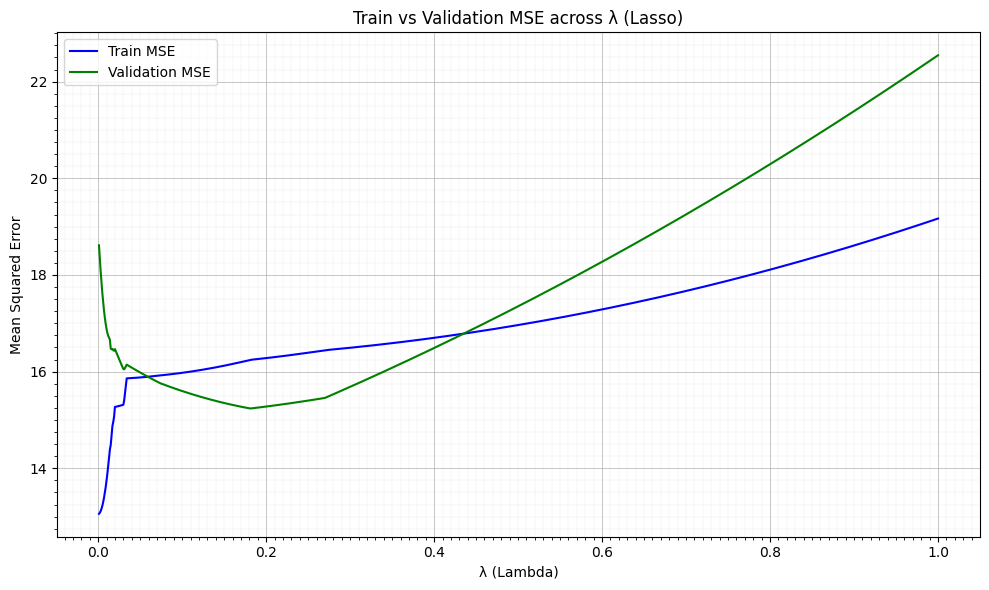

     lambda  train_mse    val_mse
0     0.001  13.058998  18.613063
1     0.002  13.079745  18.332449
2     0.003  13.114323  18.073929
3     0.004  13.162733  17.837502
4     0.005  13.224973  17.623171
..      ...        ...        ...
995   0.996  19.144053  22.497708
996   0.997  19.149910  22.509546
997   0.998  19.155772  22.521391
998   0.999  19.161640  22.533241
999   1.000  19.167514  22.545097

[1000 rows x 3 columns]


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from sklearn.linear_model import LassoLars
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- Create nonlinear dataset ---
np.random.seed(1)
x = np.linspace(1, 10, 50)
y = 12 * np.sin(x) + 0.5 * x**2 + 2 * np.exp(x / 10) + np.random.normal(0, 4, size=len(x))
df = pd.DataFrame({'x': x, 'y': y})

# --- Train/validation split ---
train_df, val_df = train_test_split(df, test_size=0.5, random_state=42)

# --- Define feature transformations ---
transformations = {
    'x': lambda x: x,
    'x^2': lambda x: x**2,
    'x^3': lambda x: x**3,
    'x^4': lambda x: x**4,
    'sin(x)': lambda x: np.sin(x),
    'cos(x)': lambda x: np.cos(x),
    'sin(2x)': lambda x: np.sin(2 * x),
    'sin(3x)': lambda x: np.sin(3 * x),
    'ln(x)': lambda x: np.log(x),
    'exp(x)': lambda x: np.exp(x / 10)
}

# --- Helper function to compute feature matrix ---
def get_features(x):
    return np.vstack([func(x) for func in transformations.values()]).T

# --- Get train and validation matrices ---
X_train = get_features(train_df['x'].values)
y_train = train_df['y'].values
X_val = get_features(val_df['x'].values)
y_val = val_df['y'].values

# --- Sweep over lambda values ---
results = []
lambdas = np.arange(0.001, 1.001, 0.001)

for alpha in lambdas:
    model = LassoLars(alpha=alpha)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_val = mean_squared_error(y_val, y_val_pred)

    results.append({
        'lambda': alpha,
        'train_mse': mse_train,
        'val_mse': mse_val
    })

# --- Convert to DataFrame ---
results_df = pd.DataFrame(results)

# --- Plot MSE curves ---
plt.figure(figsize=(10, 6))
plt.plot(results_df['lambda'], results_df['train_mse'], label='Train MSE', color='blue')
plt.plot(results_df['lambda'], results_df['val_mse'], label='Validation MSE', color='green')

plt.xlabel('λ (Lambda)')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE across λ (Lasso)')
plt.legend()

# --- Gridlines ---
ax = plt.gca()
ax.grid(True, which='major', linestyle='-', linewidth=0.5)
ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.7)

# Set minor ticks
ax.xaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

plt.tight_layout()
plt.show()

# --- Show first few rows of the table ---
print(results_df)


Now let's interrogate the plots:

* Do the shapes of the curves for the training and validation MSE values make sense?

* What is the optimal value of $\lambda$ revealed by this plot?

* How does the optimal value of $\lambda$ you determined in the previous exercise agree with this value?